# TODO:
GENERAL: Add more explanations and sources, including pointers to where inspiration has been drawn from


3. Add math explanations to forward and backward pass
4. Draw the network architecture in drawio
5. EXPERIMENT!!!!


Experimentation suggestions from Frank:
* Experiment with different activation functions (AFs) and loss/cost functions (LF/CF) (including regression and MSE).
* Experiment with input/output tensors with depth > 1  (i.e. 2).
* Experiment with a batch size > 1 (i.e. 2).

Own thoughts:
* The "Classify two probability distributions gives rise to other loss functions and mechanics, look into this!
* Fixing the "Dying ReLU" problem! https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks
* It is worth noting that this example is very contrived and only serves to provide us with numericals to use in understanding the network architecture. It is contrived as in the parameters of the distributions are fixed.


# Problem description
The following problem is proposed: 

6x6 images are generated as one of two distinct classes.

0. Class 0 represents noise as i.i.d. ~ Uniform(low, high), where low and high are parameters that determine the noise level.
1. Class 1 takes class 0 and inserts a 3x3 square by setting each element in a 3x3 grid to a predefined value, starting from a random spot in the image.

The problem then becomes to create a binary classification network that can separate these two. 

# Given
1. The network architecture  

| **Layer**   | **Input dim** | **Output dim** | **Other**                                                  |
|-------------|---------------|----------------|------------------------------------------------------------|
| Input       | 6x6           | 6x6            | Class 0 or 1                                               |
| 2D convolve | 6x6           | 4x4            | Kernel: 3x3 with stride 1 and no padding. Activation: ReLU |
| Max pool    | 4x4           | 2x2            | Kernel: 2x2 with stride 2 and no padding.                  |
| Flatten     | 2x2           | 4x1            |                                                            |
| FCNN        | 4x1           | 1              | Activation: Sigmoid                                        |

which has a total of 15 parameters, decomposed into 2 biases from the CNN and FCNN, 9 kernel weights in the CNN and 4 weights in the FCNN.

2. An input matrix *X* and a label *y*, where *y* = 0 when *X* is all uniform and *y* = 1 when *X* contains a square.

# Find
1. The intermediate values in both the CNN and FCNN part
2. Post-activation for a forward pass
3. Loss for a forward pass
3. Gradient of the loss function w.r.t. the network parameters


# Imports and helper functions

In [1829]:
import numpy as np

import matplotlib.pyplot as plt

from dataclasses import dataclass

from __future__ import annotations
from itertools import product


class Matrix2D():

    def __init__(self, array: np.ndarray):
        assert len(array.shape) == 2, "Input array must be 2D!"

        self.data: np.ndarray = array
        self.nrow: int = array.shape[0]
        self.ncol: int = array.shape[1] 

    def __getitem__(self, key):
        return self.data[key]

    def __setitem__(self, key, val):
        self.data[key] = val

    @staticmethod
    def gaussian(center, ndim, sigma = 1):

        xx, yy = np.meshgrid(
            np.linspace(0, ndim-1, ndim) - center[0],
            np.linspace(0, ndim-1, ndim) - center[1]
        )
        return Matrix2D(np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(sigma)))
        
    @staticmethod
    def uniform_noise(ndim_matrix: int, intensity: float = 1.0) -> Matrix2D:
        return Matrix2D(np.random.uniform(-intensity, intensity, (ndim_matrix, ndim_matrix)))

    @staticmethod
    def square(ndim_matrix: int, ndim_square: int) -> Matrix2D:
        matrix = Matrix2D.uniform_noise(ndim_matrix)

        # Select top left corner to draw square from
        top_left_row = np.random.randint(low=0, high = ndim_matrix - ndim_square)
        top_left_col = np.random.randint(low=0, high = ndim_matrix - ndim_square)

        matrix[top_left_row:top_left_row + ndim_square, top_left_col:top_left_col + ndim_square] = -5.0

        return matrix

    def draw(self, title: str = "") -> None:
        """Display a visualization of the matrix values

        See: https://stackoverflow.com/questions/40887753/display-matrix-values-and-colormap
        """
        fig, ax = plt.subplots()

        ax.matshow(self.data, cmap=plt.cm.Blues)

        if self.nrow == 1:
            for col in range(self.ncol):
                ax.text(col, 0, f"{self.data[0, col]:.2f}", va='center', ha='center')
        elif self.ncol == 1:
            for row in range(self.nrow):
                ax.text(0, row, f"{self.data[row, 0]:.2f}", va='center', ha='center')
        else:
            for col, row in np.ndindex(self.data.shape):
                ax.text(col, row, f"{self.data[row, col]:.2f}", va='center', ha='center')


        ax.set_title(title)

    def convolve2D(self, kernel: Matrix2D, bias: float = 0, stride: int = 1) -> Matrix2D:
        """Convolve the 2D matrix with a 2D kernel plus bias

        See http://www.songho.ca/dsp/convolution/convolution2d_example.html for the math
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - kernel.nrow) // stride + 1
        output_height: int = (self.ncol - kernel.ncol) // stride + 1

        output_image = np.zeros((output_height, output_width))

        for col, row in product(range(0, output_width, stride), range(0, output_height, stride)):
            output_image[row, col] = \
                self.data[row:row+kernel.ncol, col:col+kernel.nrow].flatten() \
                @ kernel.data.flatten() \
                + bias 

        return Matrix2D(output_image)

    def maxpool(self, ndim: int = 1, stride: int = 1):
        """Dimension reduction using the max of a neigborhood defined by ndim

        See https://computersciencewiki.org/index.php/Max-pooling_/_Pooling for the math
        and https://datascience.stackexchange.com/questions/11699/backprop-through-max-pooling-layers
        for the intuition on why the indices of the maximum values for each pool is needed
        """
        assert stride != 0, "Stride cannot be zero!"

        output_width: int = (self.nrow - ndim) // stride + 1
        output_height: int = (self.ncol - ndim) // stride + 1

        output_image = np.zeros((output_height, output_width))
        indices = []

        for row, col in product(range(output_height), range(output_width)):
            rows = slice(row * ndim, (row+1) * ndim)
            cols = slice(col * ndim, (col+1) * ndim)
            pool = self.data[rows, cols]
            
            output_image[row, col] = np.max(pool)

            index = np.add(np.unravel_index(np.argmax(pool), pool.shape), (row * col, col * row))
            indices.append(index)
        
        return Matrix2D(output_image), indices

    def flatten(self):
        return Matrix2D(self.data.flatten().reshape(self.nrow*self.ncol, 1))


@dataclass
class Network():

    learning_rate: float = 0.1

    # TODO: Make subclasses for CNN and FCNN?
    kernel: Matrix2D = None
    conv_bias: float = 0.0

    weights: np.ndarray = np.empty(0)
    fcnn_bias: float = 0.0

    backward: bool = False
    maxpool_indices: np.ndarray = np.empty(0)

    # parameters - hardcoded for this solution and will be None until the first forward pass
    z1: Matrix2D = None
    a1: Matrix2D = None
    a2: Matrix2D = None
    a3: Matrix2D = None
    z4: float = None
    a4: float = None

    def fcnn_forward(self, x):
        return self.weights @ x + self.fcnn_bias

    def relu(self, value):
        """ReLU activation"""
        act = value > 0

        if self.backward:
            return act * 1

        return act * value

    def sigmoid(self, value):
        """Sigmoid activation"""
        act = np.exp(value) / (1 + np.exp(value))

        if self.backward:
            return act * (1 - act)

        return act

    def binary_cross_entropy(self, y: float, p: float) -> float:
        """Binary cross entropy loss calculation

        See: https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html
        """
        if self.backward:
            return (1 - y) / (1 - p) - (y / p)

        return  - (y * np.log10(p) + (1 - y) * np.log10(1 - p))

    def forward_pass(self, X, y):
        self.backward = False
        
        self.z1 = X.convolve2D(self.kernel, bias=self.conv_bias, stride=1) # TODO: Move to parameter list
        self.a1 = Matrix2D(self.relu(self.z1.data))

        self.a2, self.maxpool_indices = self.a1.maxpool(ndim=2, stride=2) # TODO: Move to parameter list
        self.a3 = self.a2.flatten()

        self.z4 = self.fcnn_forward(self.a3.data)[0, 0]
        self.a4 = self.sigmoid(self.z4)

        return None if y is None else self.binary_cross_entropy(y, self.a4) 
        
    def backward_pass(self, X, y):
        self.backward = True

        delta = self.binary_cross_entropy(y, self.a4) * self.sigmoid(self.z4)
        self.fcnn_bias -= self.learning_rate * delta # Update bias for the FCNN

        delta = delta * self.a3.data 
        self.weights -= self.learning_rate * delta.T # Update weights for the FCNN

        delta_temp = np.zeros_like(self.a1.data)
        for max_indices, gradient in zip(self.maxpool_indices, delta):
            delta_temp[max_indices] = gradient

        delta = self.relu(delta_temp) * delta_temp

        grad_b1 = delta.sum()
        grad_kernel = X.convolve2D(Matrix2D(delta))

        # Update weights and bias for convolution
        self.kernel.data -= self.learning_rate * grad_kernel.data
        self.conv_bias -= self.learning_rate * grad_b1

    def predict(self, X):
        self.forward_pass(X, None)
        print(f"prob. for class 0 (no square): {1 - self.a4}")
        print(f"prob. for class 1 (square): {self.a4}")

# Example of data and usage of the Network class
Also includes a pretrained model!

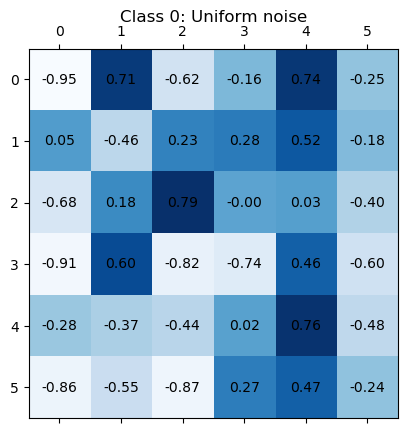

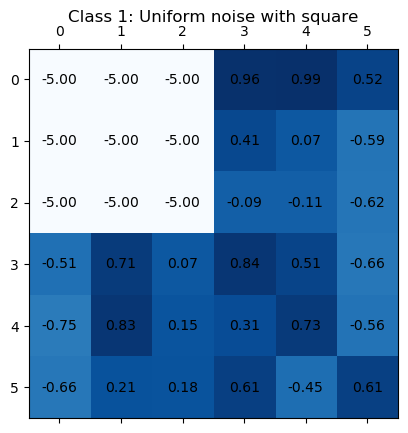

In [1830]:
np.random.seed()

# Create Matrix2D for class 0 and 1
ndim = 6

X0 = Matrix2D.uniform_noise(ndim)
X1 = Matrix2D.square(ndim, 3)
X0.draw("Class 0: Uniform noise")
X1.draw("Class 1: Uniform noise with square")


# Forward pass - annotated
The cells below provide an annotated view of the contents of the forward() function of the Network class

We start off by initializing the network parameters. This includes:
1. The 3x3 kernel, initialized with i.i.d. ~ Uniform(-1, 1) elements
2. The convolution bias, initialized as ~ Uniform(0, 1)
3. The FCNN weights, initialized with i.i.d. ~ Uniform(-1, 1) elements
4. The FCNN bias, initialized as ~ Uniform(0, 1)
These are all learnable parameters in the network.

A class 1 example image is also generated for use in the forward and backward pass example.

In [1831]:
# Initialize the network
kernel = Matrix2D(np.random.uniform(low=-1, high=1, size=(3, 3)))
conv_bias = np.random.uniform()

fcnn_weights = np.random.uniform(low=-1, high=1, size=(1, 4))
fcnn_bias = np.random.uniform()

nn = Network(learning_rate=0.01, kernel=kernel, conv_bias=conv_bias, weights=fcnn_weights, fcnn_bias=fcnn_bias)

# Use class 1 as an example
y = 1
X = Matrix2D.square(ndim, 3)

#### Convolution
Since the kernel is initialized to random values, trying to assign any meaning to the output of the convolution layer at this stage does not make sense. It is instead better to understand how the values in the convolved output image are generated. See [this gif to get a visualization of the convolution operation](https://theano-pymc.readthedocs.io/en/latest/_images/numerical_no_padding_no_strides.gif).

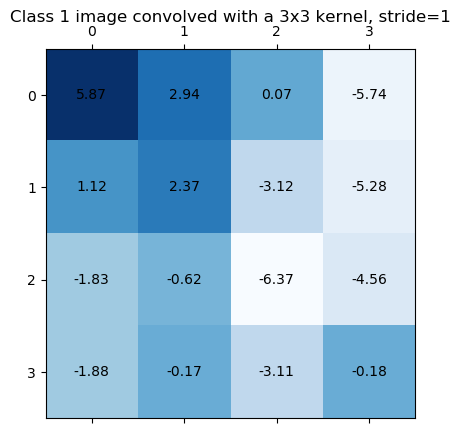

In [1832]:
z1 = X.convolve2D(kernel, bias=conv_bias, stride=1)
z1.draw("Class 1 image convolved with a 3x3 kernel, stride=1")

#### ReLU 
The ReLU function applies max(0, value) element-wise which adds a nonlinearity to the network. [[1]](http://www.cs.toronto.edu/~fritz/absps/imagenet.pdf) lists some of the benefits of having a ReLU activation, mainly sparsity and fast training times. While neither of these are problematic for such a small-scale problem as here, it yields an extra step to discuss and perform calculations on :)

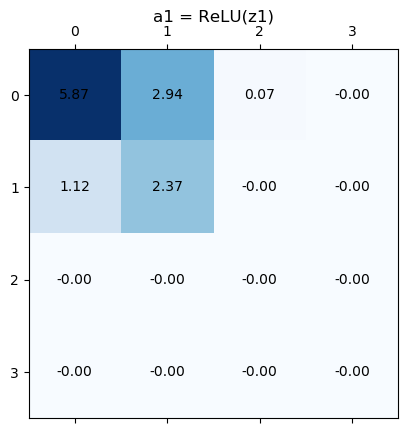

In [1833]:
a1 = Matrix2D(nn.relu(z1.data))
a1.draw("a1 = ReLU(z1)")

#### Maxpool
Our binary classifier needs a fully-connected neural network between the augmented input matrix and the output. However, due to the sparsity introduced by the ReLU operation, and for scalability concerns, it is reasonable to decimate the augmented image to a lower dimension, and this is what maxpool does. Mathematically, it is similar to convolution in that a sliding window (kernel) is applied to the image. However, instead of weighing the image elements with the kernel data, the maximum image value inside a given window is extracted to the output of the maxpool operation. Again, [I refer to an animation that visualizes this](https://thumbs.gfycat.com/FirstMediumDalmatian-size_restricted.gif).

Instead of requiring 16 weights in our FCNN, we now only need 4 - which is good - from both the perspective of parsimonity and computational demand (again, the latter is not *really* a concern for us.)

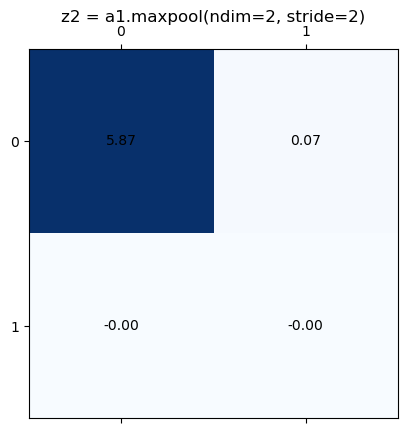

In [1834]:
a2, maxpool_indices = a1.maxpool(ndim=2, stride=2)
a2.draw("z2 = a1.maxpool(ndim=2, stride=2)")

#### FCNN

The FCNN consists of four weights, one for each cell of the maxpool output. In addition, a bias term is introduced to avoid being restricted to only being able to model functions where f(0) = 0

The pre-activation value is calculated by the dot-product between the weights and the input vector, plus bias.

Since the purpose of the network is to discriminate between two classes, a sigmoid activation is applied to the input. This ensures that the output of the network is in the range (0, 1), where values closer to 0 corresponds to the network modelling a given input as class 0, and vice versa.

To assess the performance of the network for a given (known) input, the binary cross-entropy / log-loss function is used, since the output of the sigmoid function may be interpreted as a probability. Log-loss in the binary case is a sum of two parts, each corresponding the the probability of misclassifying that class. Thus, a perfect predictor would have a log-loss of zero.

In [1835]:
a3: Matrix2D = a2.flatten()
#a3.draw("a3: a2.flatten()")

z4: float = nn.fcnn_forward(a3.data)[0, 0]
print(f"FCNN output, pre-activation:  {z4}")

a4 = nn.sigmoid(z4)
print(f"FCNN output, post-activation: {a4}")

l = nn.binary_cross_entropy(y, a4)
print(f"cross-entropy / log-loss:     {l}")

FCNN output, pre-activation:  3.4095934661475162
FCNN output, post-activation: 0.9680030132598411
cross-entropy / log-loss:     0.014123290790692387


#### Forward pass done - now what?

Through the forward pass, we have accumulated intermediate values, both in the form of scalars (FCNN pre- and post activation, log-loss) and matrices (convolved input, maxpool). The point of doing this is to set up for the *backward pass*, which ultimately leads to a way for us to update the network parameters in such a way as to increase the immediate performance of the network.
 

# Backward pass

The point of the backward pass is to compute the derivative (gradient) of the loss function with respect to the trainable parameters in the network. The intuition for this comes from the fact that, if we are able to tune the network parameters in such a way as to decrease numerical value of the loss function, then we would obtain network parameters that yield "better performance" (as modelled by the loss function).

In [1836]:

# Implementation detail, to ensure that the numerical derivatives of the
# functions in the network are used
nn.backward = True


# Chain rule backwards in the network
delta_fcnn_bias = nn.binary_cross_entropy(y, a4) * nn.sigmoid(z4)
delta_fcnn_weights = delta_fcnn_bias * a3.data 

# Undo the flattening operation
#delta = delta.reshape(a2.data.shape)

# Calculate the derivative through the maxpool operation
# Undoing the flattening operation is not needed except for visualizing, since
# I use the flattened version in the maxpool reversal
delta_temp = np.zeros_like(a1.data)
for max_indices, gradient in zip(maxpool_indices, delta_fcnn_weights):
    delta_temp[max_indices] = gradient
delta = delta_temp

# Derivative through the ReLU activation, which is simple (since relu is either const 0 or linear)
#Matrix2D(delta).draw()
delta = nn.relu(delta) * delta
#Matrix2D(delta).draw()

# Derivative through the convolution operation
grad_b1 = delta.sum()
grad_kernel = X.convolve2D(Matrix2D(delta))


# Update weights and biase for convolution
learning_rate = 0.2

nn.weights -= learning_rate * delta_fcnn_weights.T # Update weights for the FCNN
nn.fcnn_bias -= learning_rate * delta_fcnn_bias # Update bias for the FCNN

kernel.data -= learning_rate * grad_kernel.data
conv_bias -= learning_rate * grad_b1


In [1837]:
nn.backward = False
print(f"Network parameters: K = {kernel.data.flatten()}, b1 = {conv_bias}, w = {nn.weights[0]}, b2 = {nn.fcnn_bias}")

Network parameters: K = [ 0.52813864 -0.43462932  0.67852768  0.58900045  0.37227891 -0.37780532
 -0.12969571  0.21039081 -0.71646358], b1 = 0.4796190737234559, w = [ 0.55503715  0.7918982   0.46608331 -0.43855854], b2 = 0.3264318439196427


# Automatic training


In [1838]:

# Example: How to initialize network
kernel = Matrix2D(np.random.uniform(low=-1, high=1, size=(3, 3)))
conv_bias = np.random.uniform()

fcnn_weights = np.random.uniform(low=-1, high=1, size=(1, 4))
fcnn_bias = np.random.uniform()

nn = Network(learning_rate=0.01, kernel=kernel, conv_bias=conv_bias, weights=fcnn_weights, fcnn_bias=fcnn_bias)

# Create Matrix2D for class 0 and 1
ndim = 6

# Train
n_training_samples = 10000
classes = np.concatenate((np.ones(n_training_samples // 2), np.zeros(n_training_samples // 2)))
np.random.shuffle(classes)

for y in classes: 

    if y == 0:
        X = Matrix2D.uniform_noise(ndim)
    else:
        X = Matrix2D.square(ndim, 3)

    nn.forward_pass(X, y)
    nn.backward_pass(X, y)


# Test
X = Matrix2D.uniform_noise(ndim)
print("Given a matrix without a square:")
nn.predict(X)

# Project a new sample and see how the network performs
X = Matrix2D.square(ndim, 3)
print("Given a matrix with a square:")
nn.predict(X)

Given a matrix without a square:
prob. for class 0 (no square): 0.9767508603394925
prob. for class 1 (square): 0.02324913966050746
Given a matrix with a square:
prob. for class 0 (no square): 0.0027318869397844336
prob. for class 1 (square): 0.9972681130602156
